Logistic Regression
=========

Libraries:

In [1]:
# remove warnings
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt; plt.style.use("ggplot")

from sklearn.linear_model import LogisticRegression

from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, precision_recall_fscore_support, auc, accuracy_score

from scipy import interp

#### Read Data:

In [2]:
data = pd.read_csv("/media/juanan/DATA/loan_data_analysis/data/loans_processed.csv", sep = "^")\
                   .sample(200000)

In [3]:
data = data.reset_index()
data = data.drop("index", axis = 1)

In [4]:
data.head()

,num_bc_sats,num_rev_tl_bal_gt_0,grade,avg_cur_bal,pub_rec_bankruptcies,num_rev_accts,tax_liens,funded_amnt_inv,delinq_2yrs,total_bal_ex_mort,...,num_accts_ever_120_pd,total_il_high_credit_limit,bc_util,percent_bc_gt_75,sub_grade,mort_acc,num_op_rev_tl,dti,home_ownership,loan_status
0,1.0,3.0,D,31731.0,1.0,12.0,0.0,35000.0,0.0,41830.0,...,0.0,62026.0,61.1,0.0,D1,5.0,4.0,15.99,MORTGAGE,0.0
1,1.0,2.0,A,10033.0,0.0,4.0,0.0,10000.0,0.0,50163.0,...,0.0,51797.0,71.2,0.0,A2,0.0,2.0,16.18,RENT,0.0
2,5.0,5.0,B,4661.0,0.0,16.0,0.0,14000.0,1.0,27963.0,...,5.0,22800.0,67.8,40.0,B2,3.0,5.0,6.87,RENT,0.0
3,3.0,3.0,D,26147.0,0.0,4.0,0.0,35000.0,0.0,87674.0,...,0.0,36998.0,88.8,66.7,D1,5.0,3.0,17.75,RENT,1.0
4,5.0,6.0,D,26189.0,0.0,15.0,0.0,26875.0,0.0,97458.0,...,0.0,87556.0,68.7,60.0,D1,1.0,8.0,26.28,MORTGAGE,0.0


In [5]:
data.shape

(200000, 50)

#### Pre-processing:

Normalization:

In [6]:
numeric_variables = data.loc[:,data.columns != "loan_status"]._get_numeric_data().columns

In [7]:
numeric_variables

Index(['num_bc_sats', 'num_rev_tl_bal_gt_0', 'avg_cur_bal',
       'pub_rec_bankruptcies', 'num_rev_accts', 'tax_liens', 'funded_amnt_inv',
       'delinq_2yrs', 'total_bal_ex_mort', 'pct_tl_nvr_dlq', 'fico_range_low',
       'delinq_amnt', 'loan_amnt', 'installment', 'fico_range_high',
       'annual_inc', 'int_rate', 'revol_bal', 'num_bc_tl', 'num_sats',
       'tot_hi_cred_lim', 'tot_coll_amt', 'bc_open_to_buy', 'total_bc_limit',
       'open_acc', 'revol_util', 'pub_rec', 'funded_amnt', 'num_il_tl',
       'num_accts_ever_120_pd', 'total_il_high_credit_limit', 'bc_util',
       'percent_bc_gt_75', 'mort_acc', 'num_op_rev_tl', 'dti'],
      dtype='object')

In [8]:
scaler = StandardScaler()

In [9]:
scaler.fit(data[numeric_variables])

StandardScaler(copy=True, with_mean=True, with_std=True)

In [10]:
data[numeric_variables] = scaler.transform(data[numeric_variables])

In [11]:
data.head()

,num_bc_sats,num_rev_tl_bal_gt_0,grade,avg_cur_bal,pub_rec_bankruptcies,num_rev_accts,tax_liens,funded_amnt_inv,delinq_2yrs,total_bal_ex_mort,...,num_accts_ever_120_pd,total_il_high_credit_limit,bc_util,percent_bc_gt_75,sub_grade,mort_acc,num_op_rev_tl,dti,home_ownership,loan_status
0,-0.578694,-0.461509,D,1.223393,0.387256,-0.418595,-0.041975,2.445041,-0.356809,-0.085574,...,-0.296739,0.588204,0.059953,-1.317377,D1,0.168547,-0.593651,-0.219941,MORTGAGE,0.0
1,-0.578694,-0.545447,A,-0.148890,-0.087867,-1.070964,-0.041975,-0.502343,-0.356809,0.093737,...,-0.296739,0.343104,0.415571,-1.317377,A2,-0.420347,-0.764288,-0.197359,RENT,0.0
2,-0.190590,-0.293631,B,-0.488641,-0.087867,-0.092410,-0.041975,-0.030762,0.807939,-0.383967,...,0.094448,-0.351700,0.295858,-0.172995,B2,-0.067011,-0.508332,-1.303895,RENT,0.0
3,-0.384642,-0.461509,D,0.870234,-0.087867,-1.070964,-0.041975,2.445041,-0.356809,0.900906,...,-0.296739,-0.011498,1.035263,0.590880,D1,0.168547,-0.678970,-0.010757,RENT,1.0
4,-0.190590,-0.209692,D,0.872891,-0.087867,-0.173956,-0.041975,1.487141,-0.356809,1.111440,...,-0.296739,1.199935,0.327547,0.399196,D1,-0.302568,-0.252375,1.003073,MORTGAGE,0.0


Categorical Variables:

In [12]:
categorical_variables = data.select_dtypes(include="object").columns

In [13]:
def categorical_to_numeric(variable):
    
    variable_dict = dict(data.groupby(variable)['loan_status'].mean())
    
    result = data[variable].map(lambda i: variable_dict[i])
    
    return result

In [14]:
for variable in categorical_variables:
    data[variable] = categorical_to_numeric(variable)

In [15]:
data.head()

,num_bc_sats,num_rev_tl_bal_gt_0,grade,avg_cur_bal,pub_rec_bankruptcies,num_rev_accts,tax_liens,funded_amnt_inv,delinq_2yrs,total_bal_ex_mort,...,num_accts_ever_120_pd,total_il_high_credit_limit,bc_util,percent_bc_gt_75,sub_grade,mort_acc,num_op_rev_tl,dti,home_ownership,loan_status
0,-0.578694,-0.461509,0.307413,1.223393,0.387256,-0.418595,-0.041975,2.445041,-0.356809,-0.085574,...,-0.296739,0.588204,0.059953,-1.317377,0.281829,0.168547,-0.593651,-0.219941,0.179073,0.0
1,-0.578694,-0.545447,0.064450,-0.148890,-0.087867,-1.070964,-0.041975,-0.502343,-0.356809,0.093737,...,-0.296739,0.343104,0.415571,-1.317377,0.051602,-0.420347,-0.764288,-0.197359,0.238457,0.0
2,-0.190590,-0.293631,0.135265,-0.488641,-0.087867,-0.092410,-0.041975,-0.030762,0.807939,-0.383967,...,0.094448,-0.351700,0.295858,-0.172995,0.117706,-0.067011,-0.508332,-1.303895,0.238457,0.0
3,-0.384642,-0.461509,0.307413,0.870234,-0.087867,-1.070964,-0.041975,2.445041,-0.356809,0.900906,...,-0.296739,-0.011498,1.035263,0.590880,0.281829,0.168547,-0.678970,-0.010757,0.238457,1.0
4,-0.190590,-0.209692,0.307413,0.872891,-0.087867,-0.173956,-0.041975,1.487141,-0.356809,1.111440,...,-0.296739,1.199935,0.327547,0.399196,0.281829,-0.302568,-0.252375,1.003073,0.179073,0.0


In [16]:
data.shape

(200000, 50)

Target:

In [17]:
X = data.loc[:, data.columns!='loan_status']

In [18]:
y = data['loan_status']

Logistic Regression:
==========
___________________

Tuning regularization:

In [19]:
parameters = {'C': np.power(10.0, np.arange(-10, 10))}

GridSearch with Cross Validation:

In [20]:
log_reg = LogisticRegression(penalty='l2')

In [21]:
log_reg_classifier = GridSearchCV(log_reg, parameters, cv=3, scoring="roc_auc")

In [22]:
log_reg_classifier.fit(X, y)

GridSearchCV(cv=3, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': array([1.e-10, 1.e-09, 1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03,
       1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05,
       1.e+06, 1.e+07, 1.e+08, 1.e+09])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

__Cross Validation Results:__

In [23]:
pd.DataFrame(log_reg_classifier.cv_results_)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_C,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.301394,0.048487,0.658895,0.659046,1e-10,{'C': 1e-10},20,0.663618,0.657220,0.657457,0.660098,0.655609,0.659819,0.107510,0.031024,0.003424,0.001296
1,0.316258,0.026144,0.658898,0.659049,1e-09,{'C': 1e-09},19,0.663621,0.657223,0.657460,0.660101,0.655612,0.659822,0.008815,0.000614,0.003424,0.001296
2,0.302234,0.025551,0.658925,0.659076,1e-08,{'C': 1e-08},18,0.663646,0.657249,0.657487,0.660129,0.655641,0.659849,0.006455,0.001382,0.003422,0.001297
3,0.296578,0.024650,0.659191,0.659342,1e-07,{'C': 1e-07},17,0.663896,0.657506,0.657749,0.660406,0.655928,0.660115,0.014862,0.000277,0.003409,0.001304
4,0.474501,0.025478,0.661619,0.661775,1e-06,{'C': 1e-06},16,0.666182,0.659865,0.660134,0.662923,0.658540,0.662537,0.015819,0.000170,0.003292,0.001360
5,0.656035,0.028116,0.674695,0.674880,1e-05,{'C': 1e-05},15,0.678719,0.672821,0.672969,0.676330,0.672399,0.675490,0.011026,0.002097,0.002855,0.001496
6,1.168929,0.028218,0.702844,0.703085,0.0001,{'C': 0.0001},14,0.706785,0.701204,0.700267,0.704812,0.701481,0.703240,0.034726,0.004735,0.002830,0.001477
7,2.100075,0.039888,0.761464,0.761744,0.001,{'C': 0.001},13,0.765505,0.760231,0.757331,0.763959,0.761554,0.761042,0.128696,0.017911,0.003338,0.001601
8,10.271799,0.079215,0.791869,0.792167,0.01,{'C': 0.01},12,0.795123,0.790928,0.788132,0.793840,0.792350,0.791734,2.462628,0.014684,0.002874,0.001228
9,28.997687,0.144703,0.802213,0.802533,0.1,{'C': 0.1},11,0.804517,0.801676,0.799001,0.803946,0.803120,0.801979,5.655950,0.006259,0.002341,0.001006


Mean test and train scores are very close to each other, so it seems the model generalize good when new data is in.

In [24]:
log_reg_classifier.best_params_

{'C': 1000.0}

In [25]:
log_reg_classifier.best_score_

0.8048177365336985

Model Evaluation
==========
_________________

Run classifier with cross-validation and plot __ROC curves__:

In [26]:
cv = StratifiedKFold(n_splits=5)
classifier = LogisticRegression(C=1000)

In [27]:
# dataframes to numpy arrays
X = X.values
y = y.values

The following source code to plot ROC curves have been downloaded from [sklearn API](http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html) with some metrics have been added for each cross validation split:

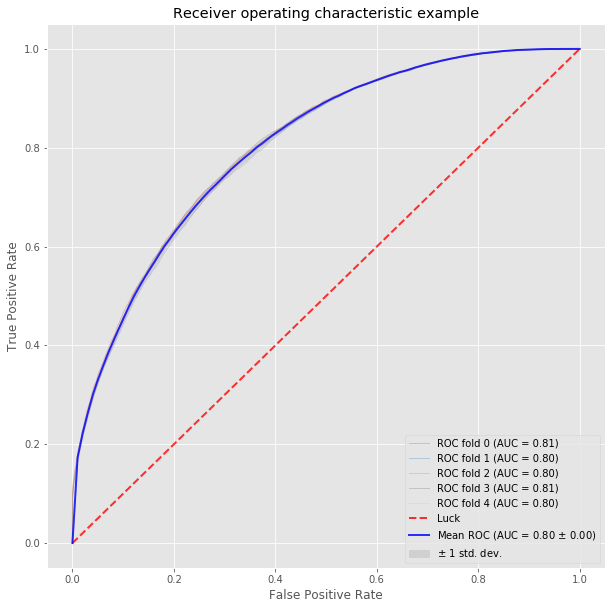

In [28]:
tprs = []
aucs = []
accuracies = []
precisions = []
recalls = []
mean_fpr = np.linspace(0, 1, 100)
plt.figure(figsize=(10,10))

i = 0
for train, test in cv.split(X, y):
    classifier.fit(X[train], y[train])
    probas_ = classifier.predict_proba(X[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)

    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
    
    # accuracy
    predictions_ = classifier.predict(X[test])
    accuracy = accuracy_score(y[test], predictions_)
    accuracies.append(accuracy)
    
    # precisions
    precision = precision_recall_fscore_support(y[test], predictions_)[0][1]
    precisions.append(precision)
    
    # recall
    recall = precision_recall_fscore_support(y[test], predictions_)[1][1]
    recalls.append(recall)
    
    i += 1

plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Luck', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

__Metrics__ in the test set:

In [29]:
metrics = pd.DataFrame(
    {"auc": aucs,
     "accuracy": accuracies, 
     "precision": precisions, 
     "recall": recalls
    })

In [30]:
metrics

,accuracy,auc,precision,recall
0,0.825404,0.807586,0.691413,0.280479
1,0.824000,0.804039,0.680695,0.279753
2,0.821825,0.800050,0.672409,0.269110
3,0.823925,0.807232,0.679461,0.280479
4,0.822896,0.804908,0.675155,0.275795


In [31]:
metrics.apply(lambda i: np.mean(i), axis = 0)

accuracy     0.823610
auc          0.804763
precision    0.679827
recall       0.277123
dtype: float64

This model has a very robust performance regardless the fold we evaluate for a sample of 200000 observations (about 25% of the total data). We can consider a good starting point for comparing with other models more complex.